# <font color=#025dfa> Görüntü İşleme ile Pnömoni Tespiti: Derin Öğrenme - Pneumonia Detection with Image Processing: A Deep Learning Approach

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, akciğer röntgen görüntülerinden pnömoni tespit etmek amacıyla derin öğrenme tabanlı bir model geliştirmeyi hedeflemektedir. Tıbbi görüntü işleme teknikleri kullanılarak, sağlıklı ve pnömoni teşhisi konulmuş akciğer röntgenlerinin sınıflandırılması gerçekleştirilecektir. Proje, doktorların teşhis sürecini hızlandırarak daha doğru sonuçlar elde etmelerine yardımcı olmayı ve sağlık hizmetlerinde erken teşhisin önemini artırmayı amaçlamaktadır.

EN = This project aims to develop a deep learning-based model to detect pneumonia from lung x-ray images. Medical image processing techniques will be used to classify healthy and pneumonia-diagnosed lung x-rays. The project aims to help doctors achieve more accurate results by accelerating the diagnosis process and to increase the importance of early diagnosis in healthcare services.

Kaynak/Source = https://thecleverprogrammer.com/2020/11/22/pneumonia-detection-with-python

Veri/Data = https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [44]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, InputLayer , Reshape , MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Tek satırda resimleri okumayı sağlıyor

from PIL import Image

In [45]:
labels = ['NORMAL','PNEUMONIA']
# TR = Etiketleri saklayacak bir liste oluşturur.
# EN = Creates a list to store the labels.

img_path = img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
# TR = Görüntü dosyalarının bulunduğu dizini veya yolunu saklayacak bir değişken oluşturur.
# EN = Creates a variable to store the directory or path where the image files are located.

In [46]:
img_list = []
label_list = []

for label in labels:
    label_path = os.path.join(img_path, label)  # TR: Etiketin dizin yolunu oluşturur. / EN: Creates the directory path for the label.

    if os.path.exists(label_path):  # TR: Klasörün var olup olmadığını kontrol eder. / EN: Checks if the folder exists.
        for img_file in os.listdir(label_path):
            img_list.append(os.path.join(label_path, img_file))
            label_list.append(label)
    else:
        print(f"Klasör bulunamadı: {label_path}")  # TR: Klasör bulunamadı mesajı verir. / EN: Prints folder not found message.

In [47]:
df = pd.DataFrame({'img': img_list, 'label': label_list})
# TR = Görüntü dosyası yollarını ve etiketlerini içeren yeni bir DataFrame oluşturur.
# EN = Creates a new DataFrame containing the image file paths and their corresponding labels.

In [48]:
d = {'NORMAL':0,'PNEUMONIA':1}
# TR = Değer içeren bir sözlük oluşturur.
# EN = Creates a dictionary containing values.

In [49]:
df['encode_label'] = df['label'].map(d)
# TR = 'label' sütunundaki etiketleri, 'd' sözlüğündeki karşılıklarıyla değiştirir ve sonuçları 'encode_label' adlı yeni bir sütuna ekler.
# EN = Maps the labels in the 'label' column to their corresponding values in the dictionary 'd' and adds the results to a new column named 'encode_label'.

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis

In [50]:
df.head()

,img,label,encode_label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0


In [51]:
df.sample(5)

,img,label,encode_label
1795,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
3361,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
2023,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1
2152,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA,1


In [52]:
df.shape

(5216, 3)

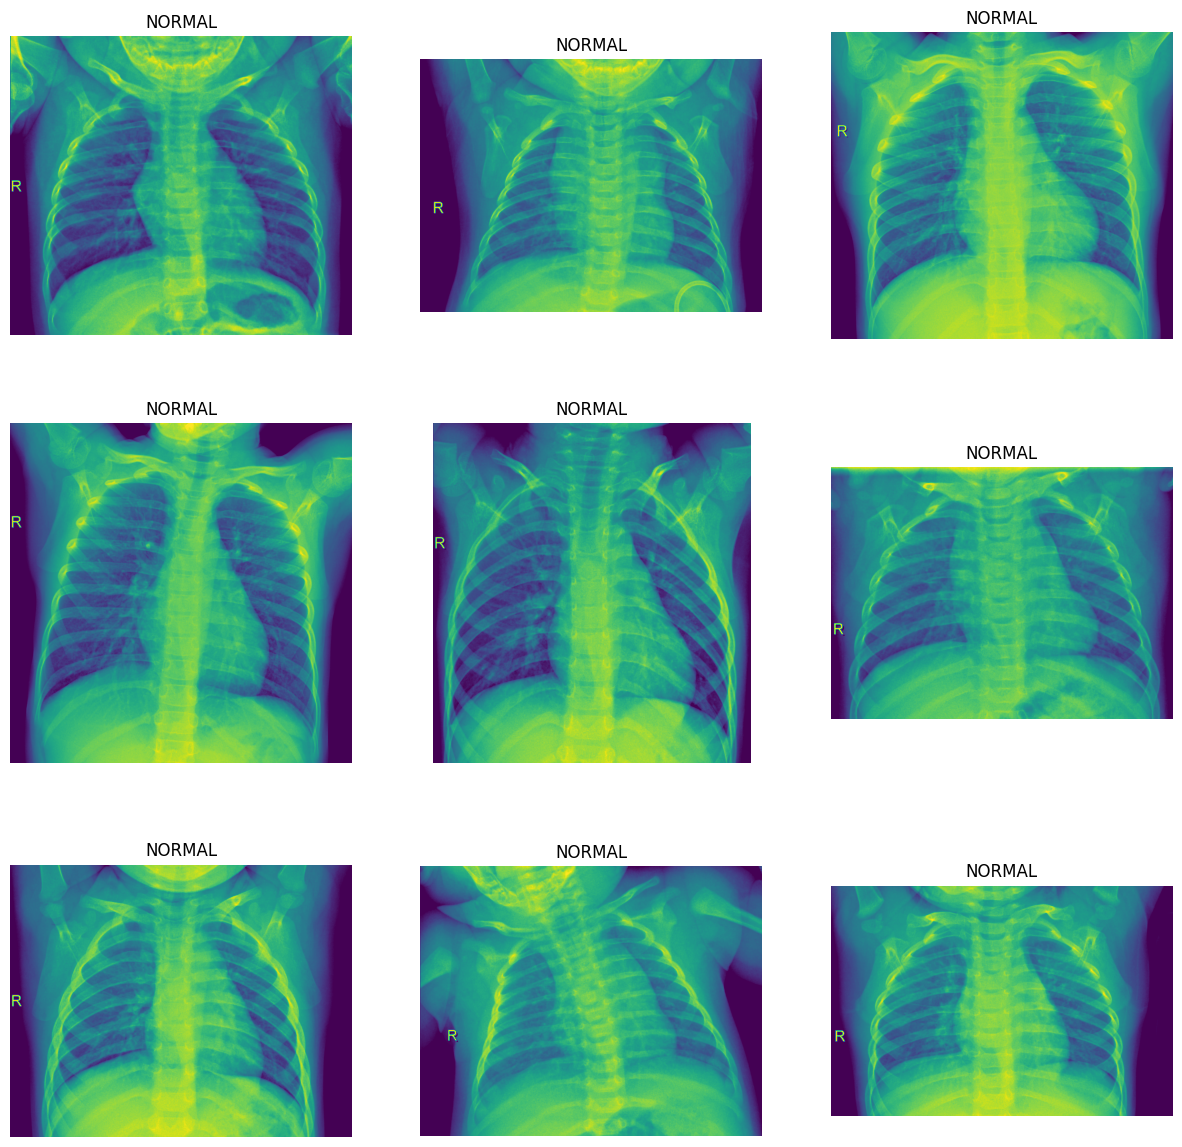

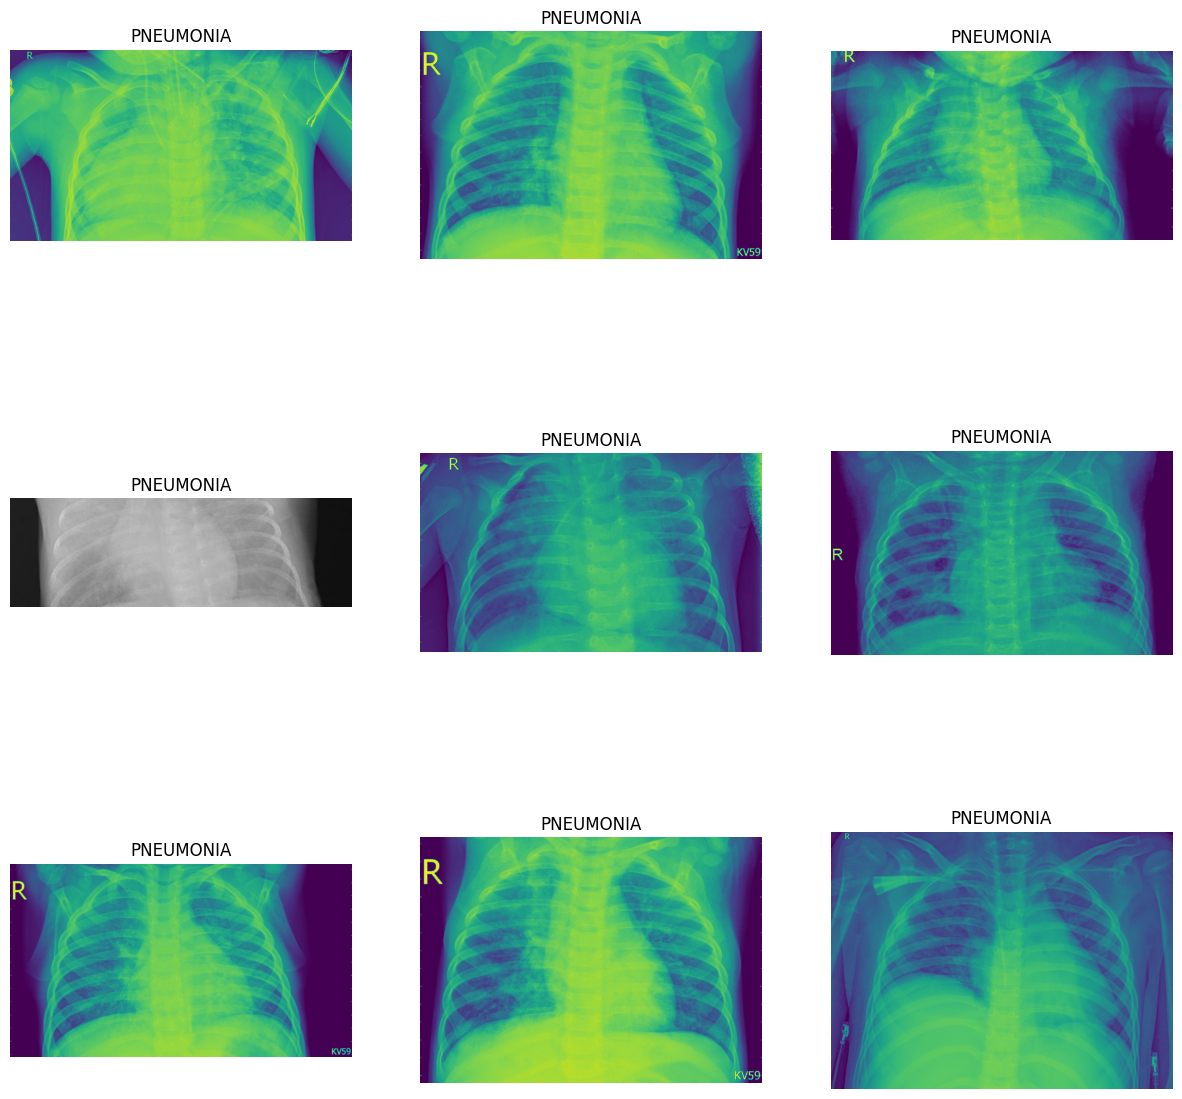

In [53]:
for label in labels:  
    # TR = Her etiket için döngü başlatılır  
    # EN = Start loop for each label
    
    label_images = df[df['label'] == label]['img'].tolist()  
    # TR = İlgili etiketle eşleşen tüm görüntü yolları bir listeye alınır  
    # EN = All image paths matching the label are retrieved into a list

    if len(label_images) >= 9:  
        # TR = Eğer görüntü sayısı 9 veya daha fazlaysa işlem devam eder  
        # EN = Proceed if there are 9 or more images

        selected_images = random.sample(label_images, 9)  
        # TR = Görüntüler arasından rastgele 9 tanesi seçilir  
        # EN = Randomly select 9 images from the list
        
        plt.figure(figsize=(15, 15))  
        # TR = 15x15 boyutlarında bir figür oluşturulur  
        # EN = Create a figure of size 15x15
        
        for i, img_path in enumerate(selected_images):  
            # TR = Seçilen her bir görüntü için döngü başlatılır  
            # EN = Loop through each selected image
            
            img = mpimg.imread(img_path)  
            # TR = Görüntü dosyası okunur  
            # EN = Read the image file
            
            plt.subplot(3, 3, i + 1)  
            # TR = 3x3'lük bir yerleşimde görüntü konumlandırılır  
            # EN = Place the image in a 3x3 grid
            
            plt.imshow(img)  
            # TR = Görüntü ekranda gösterilir  
            # EN = Display the image
            
            plt.title(label)  
            # TR = Her görüntüye ait başlık olarak etiket eklenir  
            # EN = Set the label as the title for each image
            
            plt.axis('off')  
            # TR = Eksenler gizlenir  
            # EN = Hide the axes
        
        plt.show()  
        # TR = Görüntüler ekranda gösterilir  
        # EN = Display the images on the screen
        
    else:  
        # TR = Eğer yeterli görüntü yoksa uyarı verir  
        # EN = If not enough images are available, show a warning message
        
        print(f"Yeterli görüntü bulunamadı/Not enough images found: {label}")  
        # TR = Ekranda yeterli görüntü bulunamadığını belirtir  
        # EN = Print a message that not enough images were found


In [54]:
x = []
# TR = Görüntüleri saklayacak bir liste oluşturur.
# EN = Creates a list to store the images.

size = 64
# TR = Görüntülerin yeniden boyutlandırılacağı hedef boyutu belirler.
# EN = Sets the target size to which images will be resized.

for img in df['img']:
    img = cv2.imread(str(img))
    # TR = Görüntüyü dosyadan okur. 'str(img)' dosya yolunu belirtir.
    # EN = Reads the image from file. 'str(img)' specifies the file path.

    img = cv2.resize(img, (size, size))
    # TR = Görüntüyü belirtilen boyuta yeniden boyutlandırır, burada her iki boyut size olarak belittik.
    # EN = Resizes the image to the specified size, where we specify both dimensions as size.

    img = img / 255.0
    # TR = Görüntüyü normalleştirir, pixel değerlerini 0 ile 1 arasına çeker.
    # EN = Normalizes the image, scaling pixel values to be between 0 and 1.

    x.append(img)
    # TR = Normalleştirilmiş ve yeniden boyutlandırılmış görüntüyü listeye ekler.
    # EN = Appends the normalized and resized image to the list.

In [55]:
x=np.array(x)
# TR = Yazıyı resim olarak okuyor bu yüzden diziye çevirdik.
# EN = The text is read as an image, so we converted it to an array

In [56]:
y=df['encode_label']

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling

In [57]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik.
# EN = We trained our model.

In [58]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [59]:
model = Sequential()
# TR = Ardışık bir model oluşturur, katmanlar sıralı olarak eklenir.
# EN = Creates a sequential model where layers are added in a linear stack.

model.add(InputLayer(input_shape=(size,size,3)))
# TR = Modelin giriş katmanını tanımlar ve veri boyutunu belirtir.
# EN = Defines the input layer of the model and specifies the data dimensions.

model.add(Reshape(target_shape=(size,size,3)))
# TR = Veriyi sizexsizex3 şeklinde yeniden düzenler, gri tonlama görüntüleri için tek bir renk kanalını belirtir.
# EN = Reshapes the data to sizexsizex3, specifying a single color channel for grayscale images.

model.add(Conv2D(filters=12, kernel_size=(3,3), activation='relu'))
# TR = Konvolüsyon işlemi ile özellikleri çıkarır, filtreler görüntüdeki desenleri öğrenir ve 'relu' aktivasyon fonksiyonu ile doğrusal olmayan ilişkileri modellemesini sağlar.
# EN = Extracts features via convolution, where filters learn patterns in the image and the 'relu' activation function introduces non-linearity.

model.add(MaxPooling2D(pool_size=(2,2)))
# TR = Özellik haritasını küçültür ve en belirgin özellikleri seçer, böylece hesaplama maliyeti azalır ve modelin genelleştirme yeteneği artar.
# EN = Reduces the feature map size and selects the most prominent features, reducing computation and improving the model’s ability to generalize.

model.add(Flatten())
# TR = Çok boyutlu veri kümesini tek boyutlu bir vektöre dönüştürür, tam bağlantılı katmanlarla işlem için uygun hale getirir.
# EN = Converts the multi-dimensional feature map into a one-dimensional vector to be processed by fully connected layers.

model.add(Dense(5))
# TR = Sonuçları 5 farklı sınıfa dönüştüren bir tam bağlantılı katman ekler, bu da modelin sınıflandırma yapmasını sağlar.
# EN = Adds a fully connected layer with 10 units to output results for 10 different classes, enabling classification.

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# TR = Modeli 'adam' optimizasyonu ile derler, bu optimizasyon algoritması öğrenmeyi iyileştirir, ve 'SparseCategoricalCrossentropy' kayıp fonksiyonunu kullanarak çok sınıflı sınıflandırma yapar, doğruluk metriğiyle model performansını değerlendirir.
# EN = Compiles the model with the 'adam' optimizer, which improves learning, uses 'SparseCategoricalCrossentropy' loss function for multi-class classification, and evaluates performance with accuracy metric.

history=model.fit(x_train, y_train, validation_split=.10, epochs=10)
# TR = Modeli eğitim verileri (train_images) ve etiketleri (train_labels) ile eğitir, %10'luk bir doğrulama seti kullanır ve 10 dönem boyunca eğitir.
# EN = Trains the model with the training data (train_images) and labels (train_labels), uses 10% of the data for validation, and trains for 10 epochs.

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7728 - loss: 0.5226 - val_accuracy: 0.9474 - val_loss: 0.1659
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9515 - loss: 0.1508 - val_accuracy: 0.9282 - val_loss: 0.1952
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9689 - loss: 0.1089 - val_accuracy: 0.9641 - val_loss: 0.1017
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9611 - loss: 0.1045 - val_accuracy: 0.9617 - val_loss: 0.1041
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9733 - loss: 0.0790 - val_accuracy: 0.9665 - val_loss: 0.0850
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9751 - loss: 0.0693 - val_accuracy: 0.9617 - val_loss: 0.0863
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9747 - loss: 0.0728 - val_accuracy: 0.9689 - val_loss: 0.0818
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9825 - loss: 0.0578 - val_accu

In [60]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 12)     │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11532)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │        57,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,005 (679.71 KB)

 Trainable params: 58,001 (226.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,004 (453.14 KB)

In [61]:
loss, _accuracy = model.evaluate(x_test, y_test)
# TR = Test verileri (test_images) ve etiketleri (test_labels) ile modelin performansını değerlendirir, kayıp ve doğruluk değerlerini döndürür.
# EN = Evaluates the model's performance using test data (test_images) and labels (test_labels), returning loss and accuracy values.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9538 - loss: 0.1192


In [62]:
pred = model.predict(x_test)  
# TR = Modelin test verisi üzerinde tahmin yapması sağlanır  
# EN = The model makes predictions on the test data

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [64]:
pred

array([[ -0.30926853,   5.716664  , -11.108428  , -11.1047535 ,
        -11.13473   ],
       [  4.302069  ,   4.4031954 , -12.810796  , -12.8614235 ,
        -12.819883  ],
       [ -0.32077035,   8.19478   , -12.703684  , -12.657646  ,
        -12.532567  ],
       ...,
       [ -3.3357701 ,   9.656164  , -11.593165  , -11.600231  ,
        -11.611912  ],
       [  4.150644  ,   4.3551364 , -14.060918  , -13.9822445 ,
        -14.082878  ],
       [ -0.3281296 ,   7.6746607 , -12.619386  , -12.610021  ,
        -12.62574   ]], dtype=float32)

In [66]:
pred = np.argmax(pred, axis=1)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [67]:
y_test

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [68]:
y_test = np.argmax(y_test, axis=1)
y_test

array([1, 0, 1, ..., 1, 0, 1])

In [69]:
accuracy = accuracy_score(y_test, pred)  
# TR = Doğruluk skoru hesaplanır  
# EN = Calculate the accuracy score

print(f'Accuracy Score: {accuracy}')  
# TR = Doğruluk skoru ekrana yazdırılır  
# EN = Print the accuracy score to the screen

cm = confusion_matrix(y_test, pred)  
# TR = Karışıklık matrisi hesaplanır  
# EN = Calculate the confusion matrix

print(f'Confusion Matrix:\n{cm}')  
# TR = Karışıklık matrisi ekrana yazdırılır  
# EN = Print the confusion matrix to the screen

report = classification_report(y_test, pred)  
# TR = Sınıflandırma raporu oluşturulur  
# EN = Generate the classification report

print(f'Classification Report:\n{report}')  
# TR = Sınıflandırma raporu ekrana yazdırılır  
# EN = Print the classification report to the screen


Accuracy Score: 0.9636015325670498
Confusion Matrix:
[[257  30]
 [  8 749]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       287
           1       0.96      0.99      0.98       757

    accuracy                           0.96      1044
   macro avg       0.97      0.94      0.95      1044
weighted avg       0.96      0.96      0.96      1044



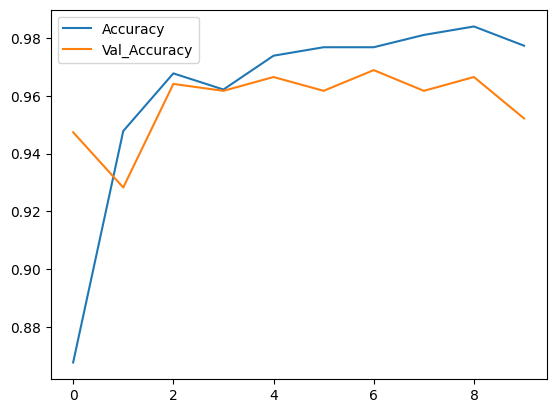

In [70]:
plt.plot(history.history['accuracy'],label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_Accuracy')
plt.legend();